In [14]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from main import RNNLayer
import ast
import DSA
import copy
from notebooks.utils_rnn import *
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load config

In [15]:
config = load_config("../config.yaml")
taskset = "PDM"

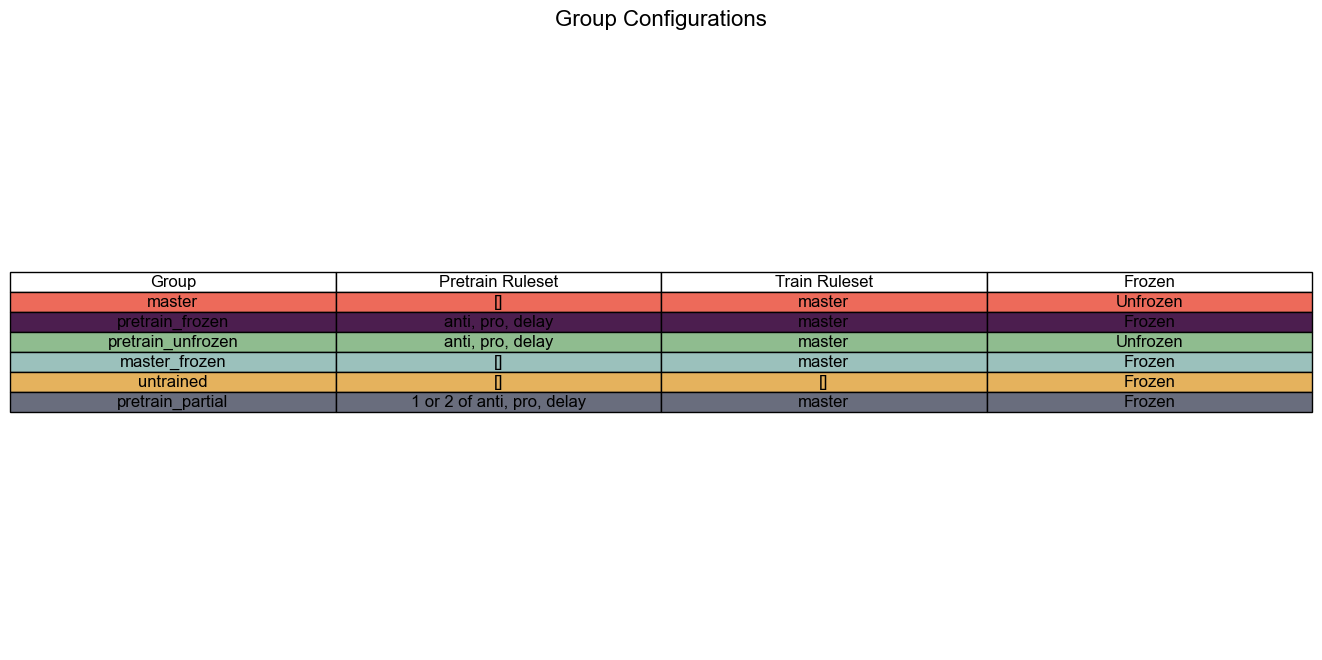

In [16]:
visualize_reduced_plots(color_mapping)

### Get dissimilarities

#### Computation dynamics

In [17]:
path = f"../data/dissimilarities/{taskset}/"
df = get_dataframe(path, taskset)
df_selected, models_trained_per_group = select_df(df)



In [18]:
group_pairs = find_group_pairs(config, taskset)
dissimilarities_per_shared_task = dissimilarities_per_percentage_of_shared_task(group_pairs, df_selected)

#### Learning dynamics

For now, only analysis for pretrain_frozen against pretrain_unfrozen

In [19]:
dissimilarities_groups, groups_training = get_dissimilarities_groups(taskset, models_trained_per_group)

/Users/qguilhot/Library/Mobile Documents/com~apple~CloudDocs/ETHZ/RepAL/notebooks/utils_rnn.py:779: RuntimeWarning: Mean of empty slice
  np.nanstd(dissimilarities_interpolated[measure][group])
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/repal-8PB6Q6y1-py3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [20]:
for measure in dissimilarities_per_shared_task:
    X = []  # Store shared_tasks as X
    y = []  # Store dissimilarities as y
    print(measure)
    # Aggregate all (shared_task, dissimilarity) pairs across all models
    for shared_tasks, models_data in dissimilarities_per_shared_task[measure].items():
        for model, dissimilarity_list in models_data.items():
            dissimilarity = dissimilarity_list[
                0
            ]  # Extract the single dissimilarity value for the current model
            X.append(shared_tasks)
            y.append(dissimilarity)
    print(f"len(y): {len(y)}")
    print(f"x: {X}")
    print(f"y: {y}")

dsa
len(y): 220
x: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
y: [0.10472925007343292, 0.07490941882133484, 0.024519432336091995, 0.05216865986585617, 0.067228965

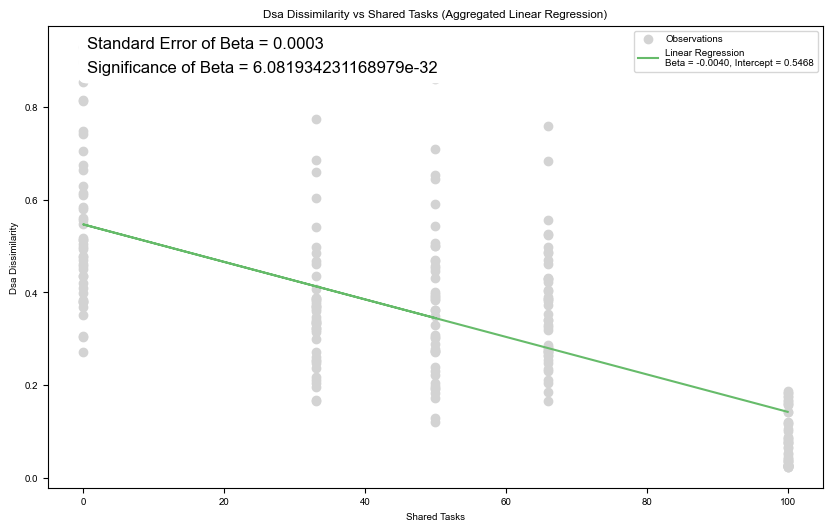

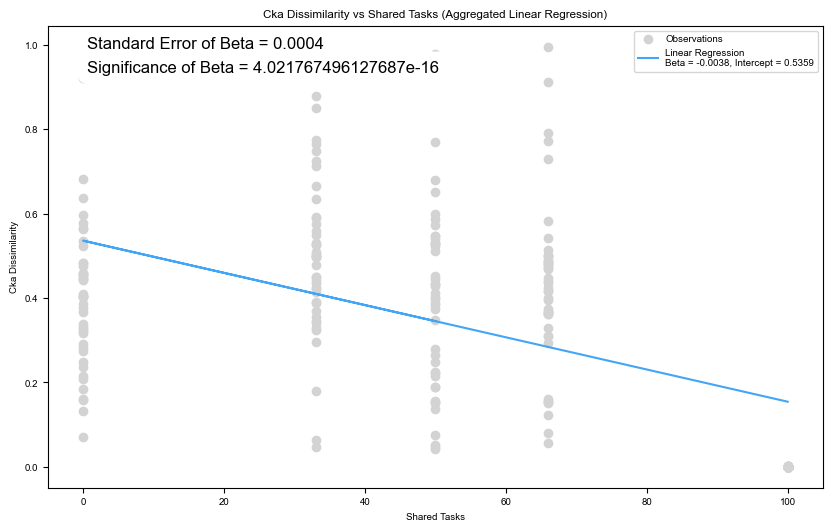

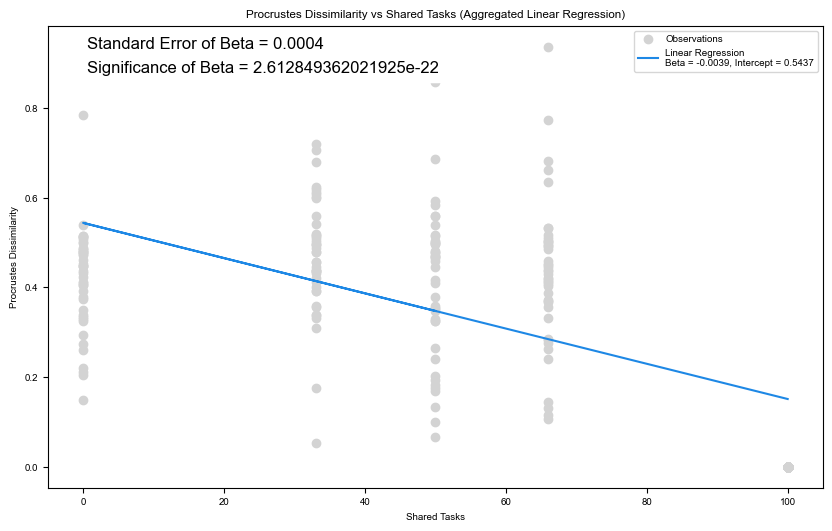

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Iterate over each measure to compute linear regression and uncertainty
for measure in dissimilarities_per_shared_task:
    X = []  # Store shared_tasks as X
    y = []  # Store dissimilarities as y

    # Aggregate all (shared_task, dissimilarity) pairs across all models
    for shared_tasks, models_data in dissimilarities_per_shared_task[measure].items():
        for model, dissimilarity_list in models_data.items():
            dissimilarity = dissimilarity_list[
                0
            ]  # Extract the single dissimilarity value for the current model
            X.append(shared_tasks)
            y.append(dissimilarity)

    # Convert to numpy arrays for linear regression
    X = np.array(X).reshape(-1, 1)  # Reshape to a 2D array
    y = np.array(y)

    # Perform linear regression using least squares estimator
    model = LinearRegression()
    model.fit(X, y)

    # Get the slope (beta) and intercept
    beta = model.coef_[0]
    intercept = model.intercept_

    # Predict y values for the regression line
    y_pred = model.predict(X)

    # Compute residuals and their variance
    residuals = y - y_pred
    residual_variance = np.var(
        residuals, ddof=2
    )  # ddof=2 because we have 2 parameters estimated (slope and intercept)

    # Compute variance of X
    X_mean = np.mean(X)
    X_variance = np.sum((X - X_mean) ** 2)

    # Standard error of the slope (beta)
    standard_error_beta = np.sqrt(residual_variance / X_variance)

    t_statistic = beta / standard_error_beta
    df = len(X) - 2  # degrees of freedom
    p_value = 2 * stats.t.sf(np.abs(t_statistic), df)

    # Mis-specification error (Mean Squared Error)
    mse = np.mean(residuals**2)

    # Plot all observations and the regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color="lightgray", label="Observations")
    plt.plot(
        X,
        y_pred,
        "-",
        color=color_mapping_metrics[measure],
        label=f"Linear Regression\nBeta = {beta:.4f}, Intercept = {intercept:.4f}",
    )

    # Annotate the plot with Standard Error of Beta and Mis-specification Error
    plt.annotate(
        f"Standard Error of Beta = {standard_error_beta:.4f}",
        xy=(0.05, 0.95),
        xycoords="axes fraction",
        fontsize=12,
        bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.5"),
    )
    plt.annotate(
        f"Mis-specification Error (MSE) = {mse:.4f}",
        xy=(0.05, 0.90),
        xycoords="axes fraction",
        fontsize=12,
        bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.5"),
    )
    plt.annotate(
        f"Significance of Beta = {p_value}",
        xy=(0.05, 0.90),
        xycoords="axes fraction",
        fontsize=12,
        bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.5"),
    )

    plt.xlabel("Shared Tasks")
    plt.ylabel(f"{measure.capitalize()} Dissimilarity")
    plt.title(
        f"{measure.capitalize()} Dissimilarity vs Shared Tasks (Aggregated Linear Regression)"
    )
    plt.legend()
    plt.show()

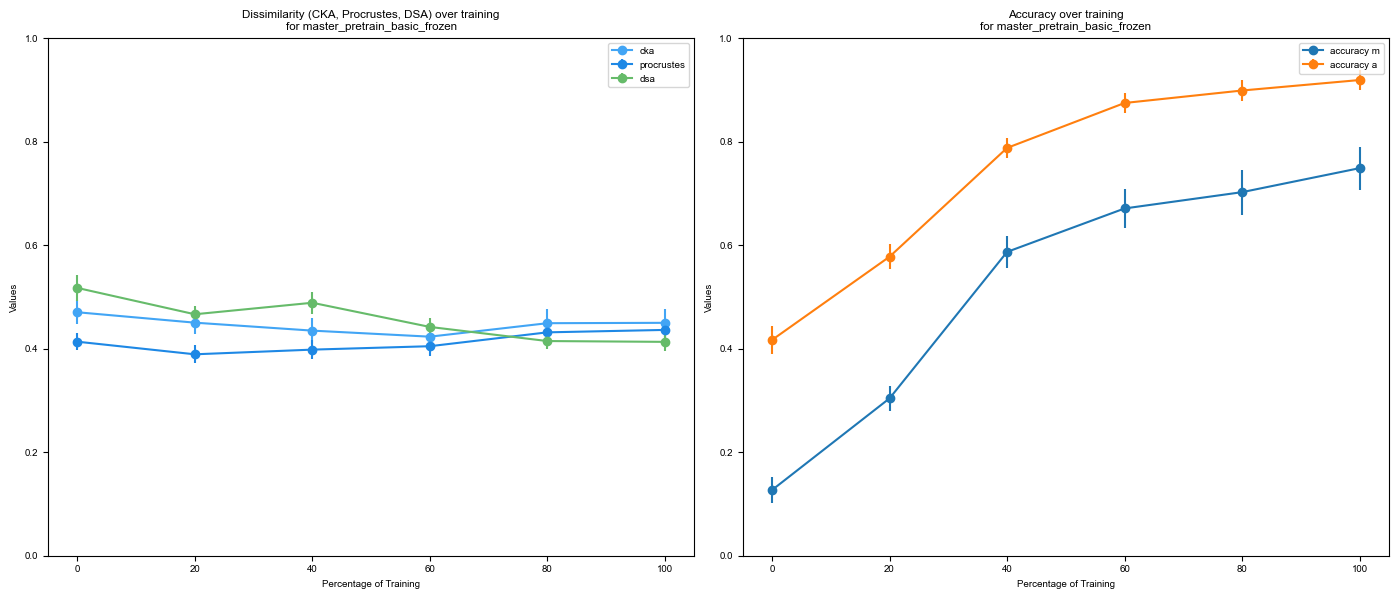

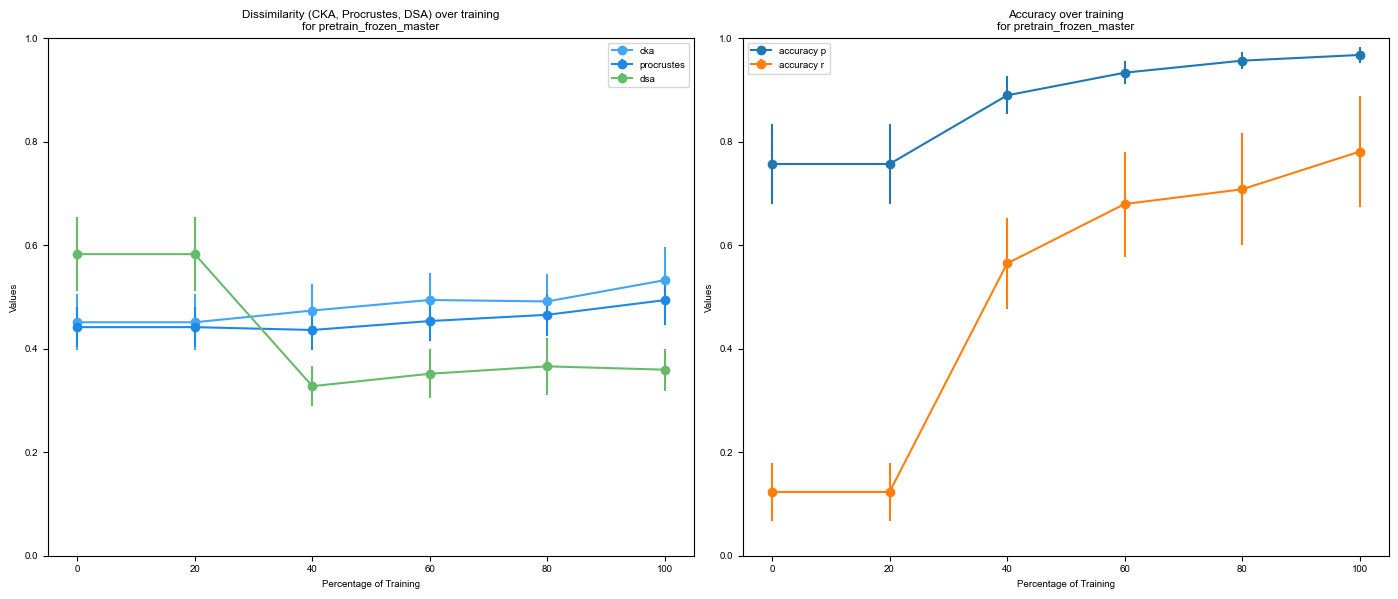

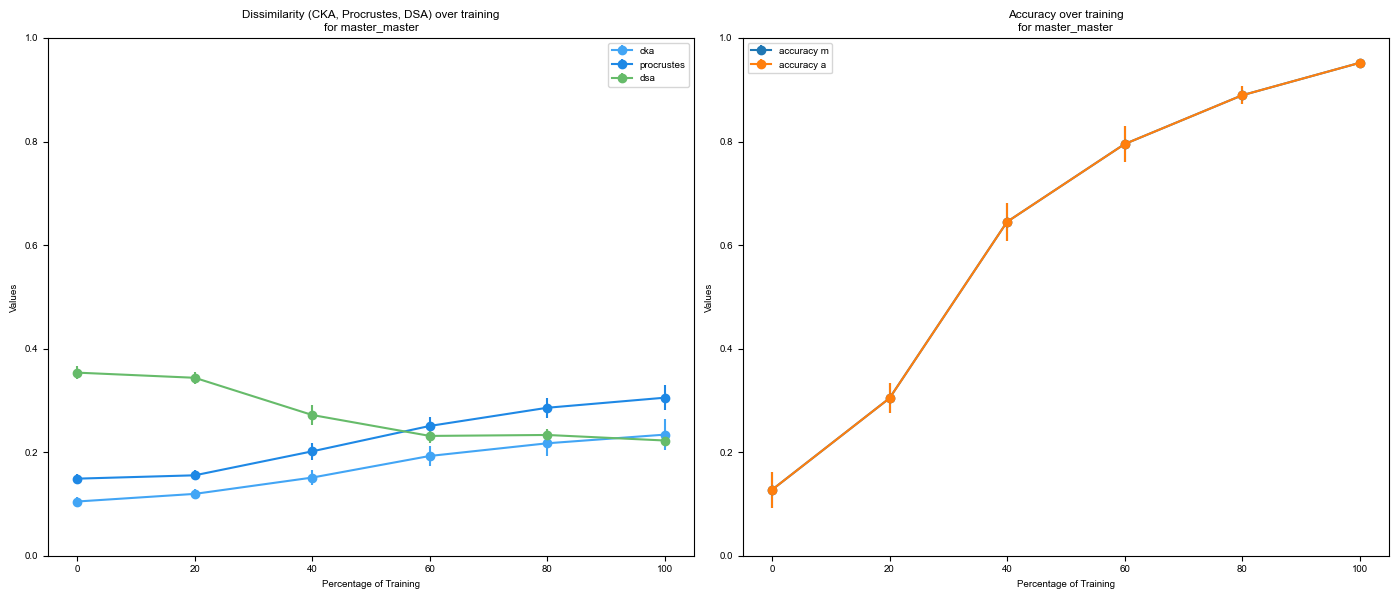

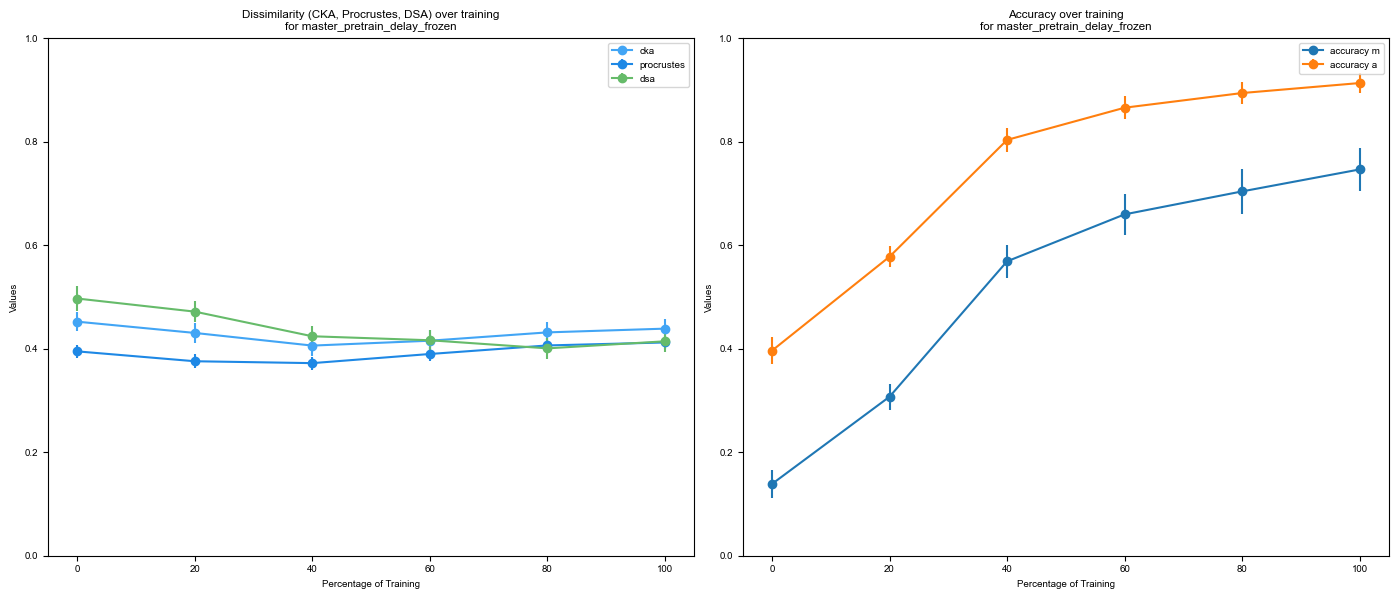

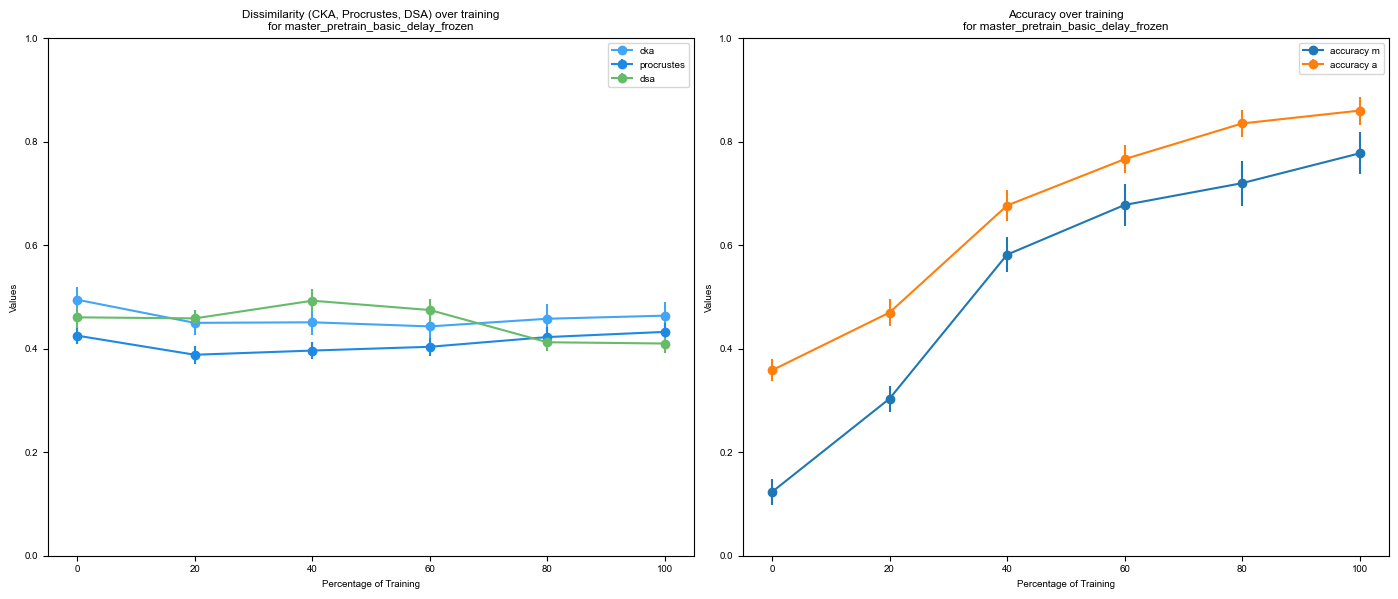

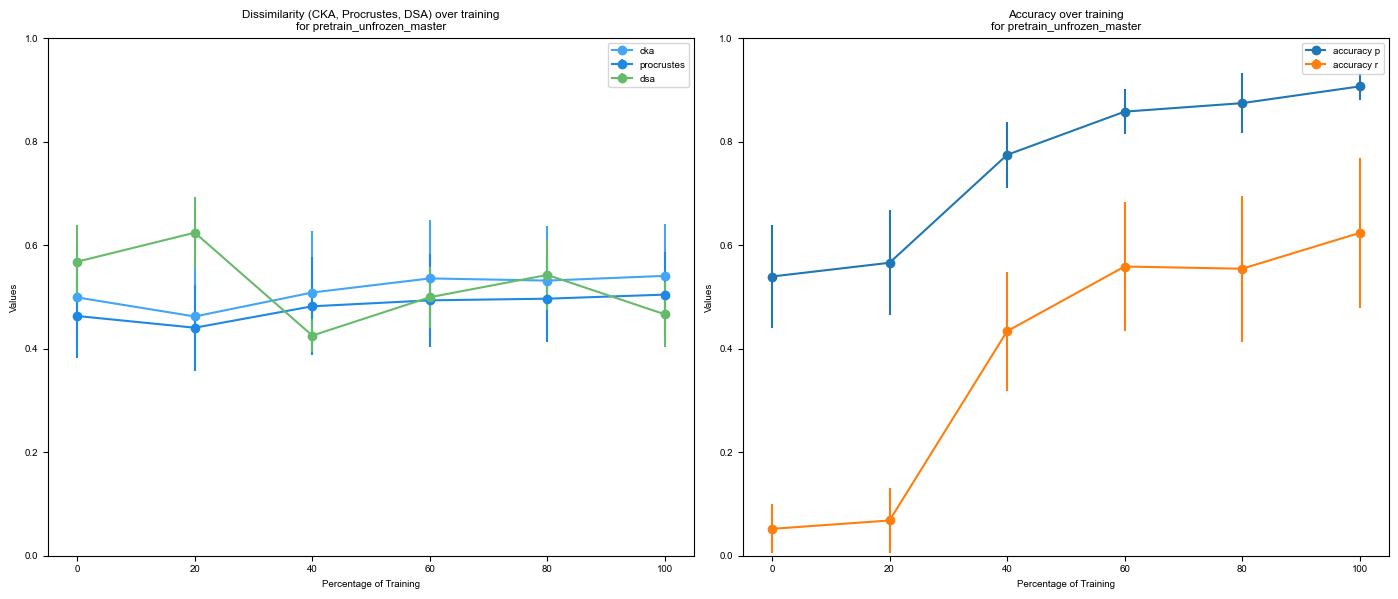

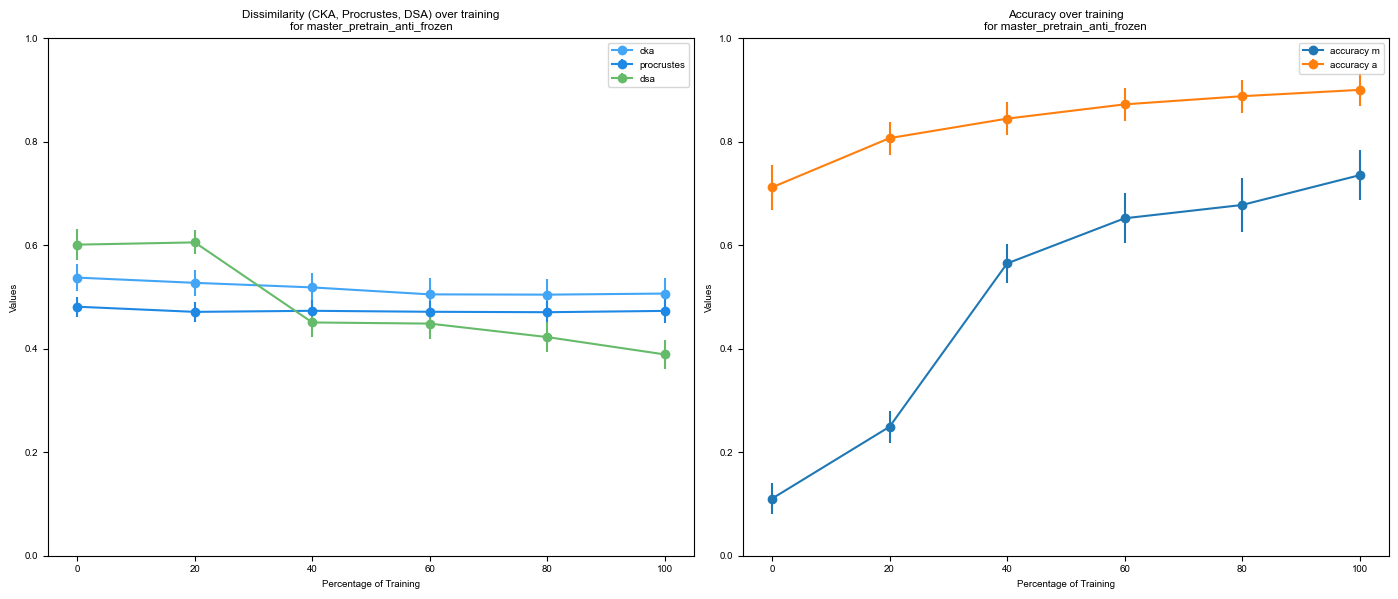

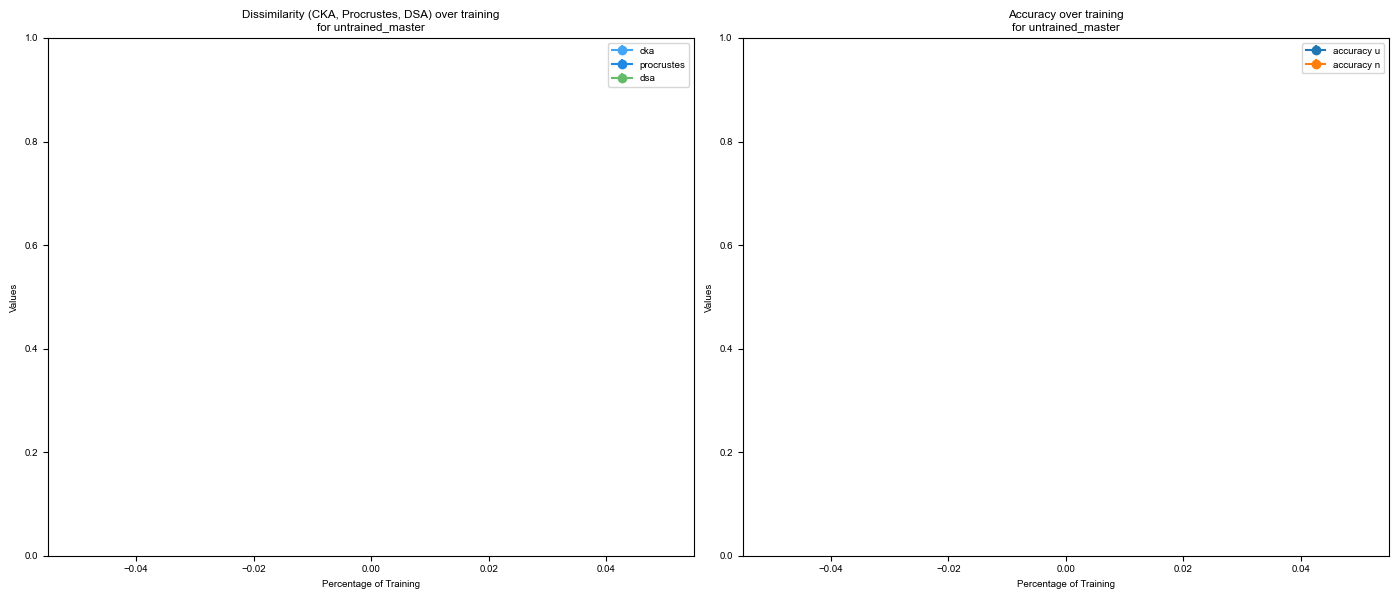

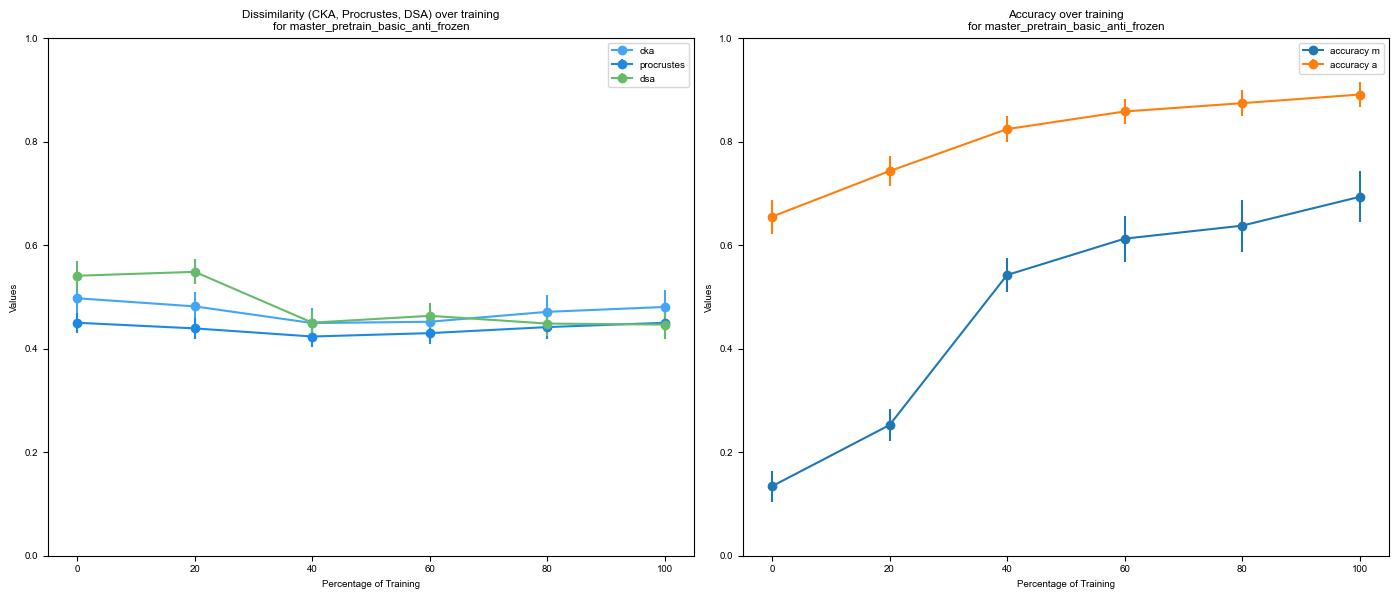

In [22]:
import os
from turtle import color
import numpy as np
import matplotlib.pyplot as plt

# Assuming dissimilarities_groups is defined from your previous code

# Iterate over each group in groups_training
for group_training in groups_training:
    if "master_frozen" not in group_training:
        dissimilarities_interpolated = dissimilarities_groups[group_training]

        # X-axis values
        x_values = [i * 20 for i in range(6)]

        # Measures for the two plots
        measures_plot1 = ["cka", "procrustes", "dsa"]
        measures_plot2 = ["accuracy_1", "accuracy_2"]

        # Create the figure and the two subplots
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

        # Plot for the first set of measures
        for key in measures_plot1:
            dictionary_measures = dissimilarities_interpolated[key]
            means = [value[0] for value in dictionary_measures.values()]
            errors = [value[1] for value in dictionary_measures.values()]
            axs[0].errorbar(x_values, means, yerr = errors,marker="o", label=key, color=color_mapping_metrics[key])

        axs[0].set_xlabel("Percentage of Training")
        axs[0].set_ylabel("Values")
        axs[0].set_title(
            "Dissimilarity (CKA, Procrustes, DSA) over training\nfor {}".format(
                group_training
            )
        )
        axs[0].set_ylim(0, 1)
        axs[0].legend()
        axs[0].grid(False)

        # Plot for the second set of measures
        for i, key in enumerate(measures_plot2):
            dictionary_measures = dissimilarities_interpolated[key]
            means = [value[0] for value in dictionary_measures.values()]
            errors = [value[1] for value in dictionary_measures.values()]
            # Rename legend label for accuracy
            label = f"accuracy {group_training[i]}"
            axs[1].errorbar(x_values, means, yerr= errors, marker="o", label=label)

        axs[1].set_xlabel("Percentage of Training")
        axs[1].set_ylabel("Values")
        axs[1].set_title("Accuracy over training\nfor {}".format(group_training))
        axs[1].set_ylim(0, 1)
        axs[1].legend()
        axs[1].grid(False)

        # Adjust layout to avoid overlapping elements
        plt.tight_layout()

        # Display the plots
        plt.show()

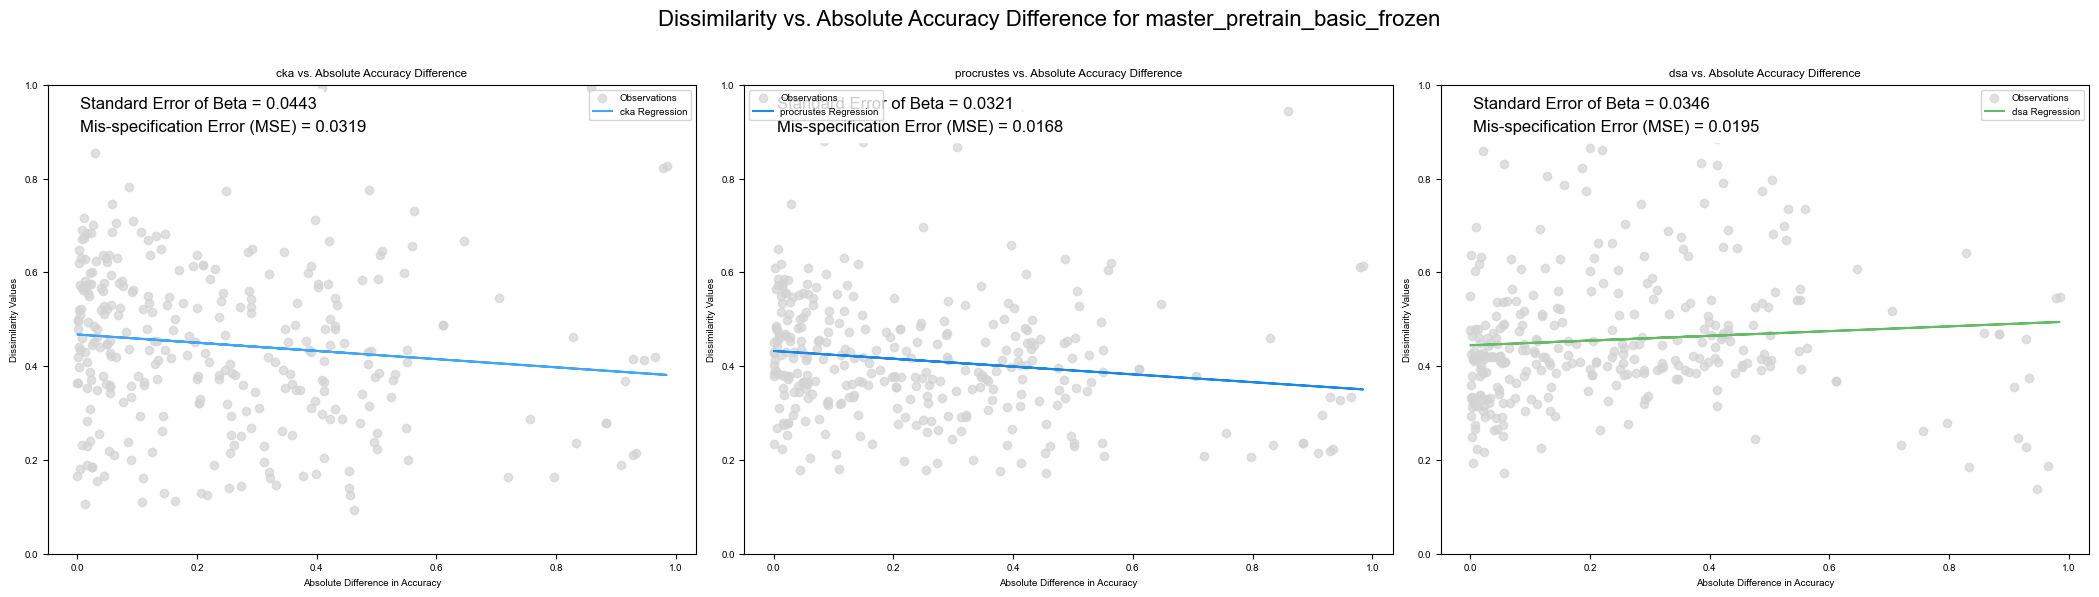

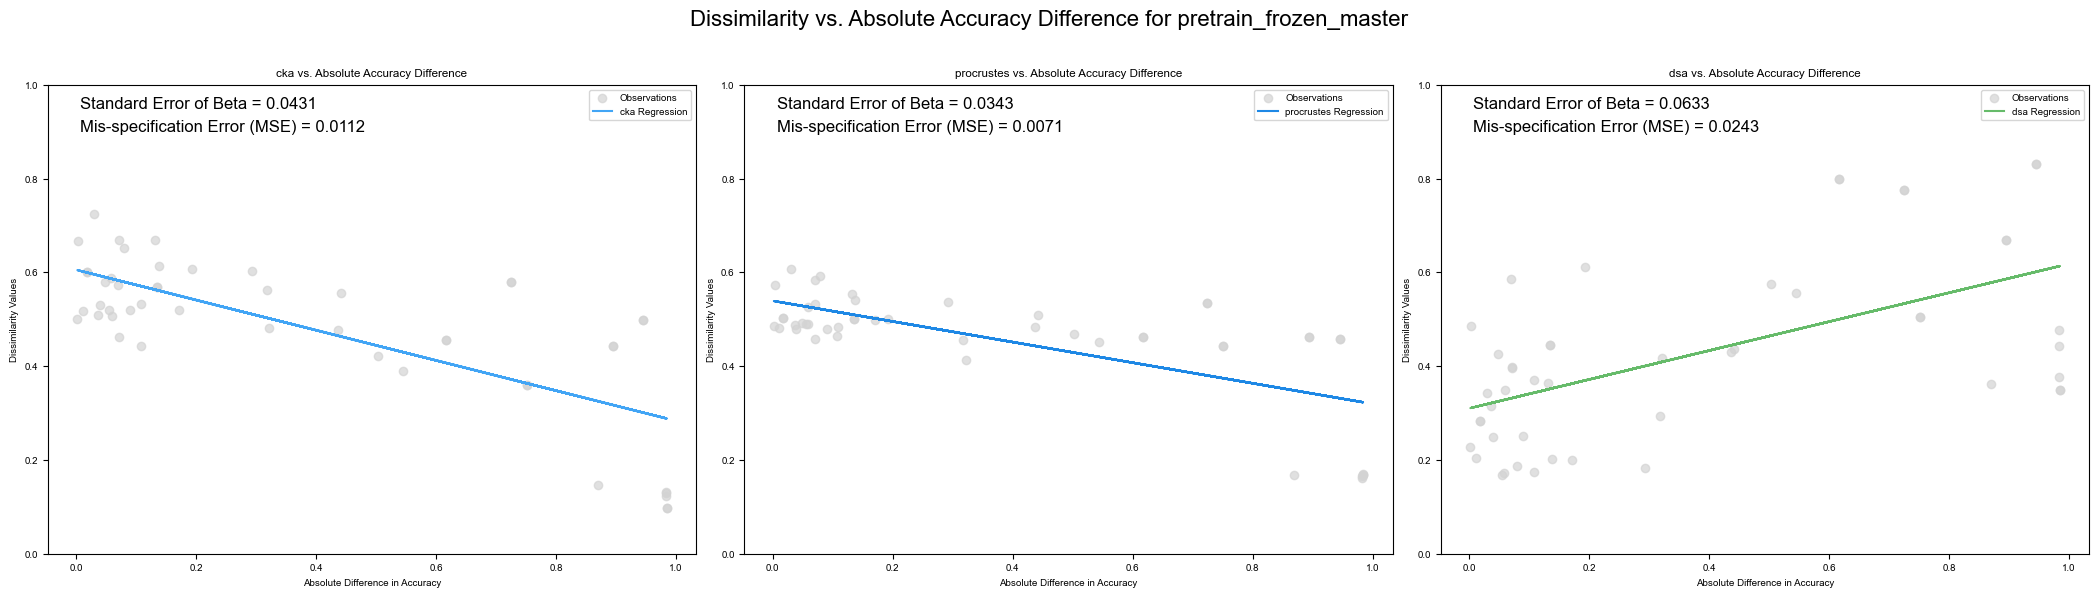

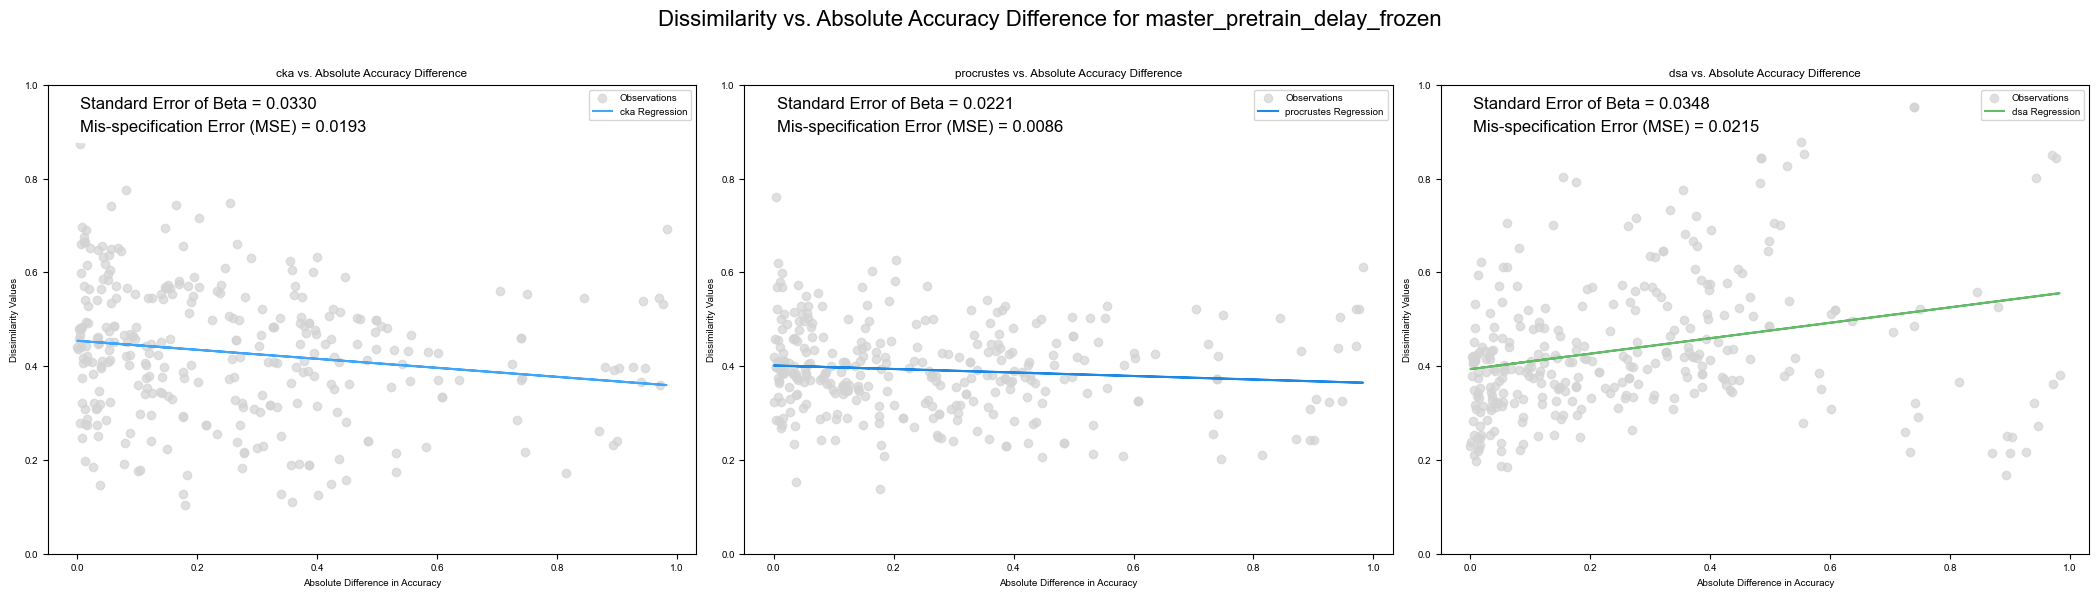

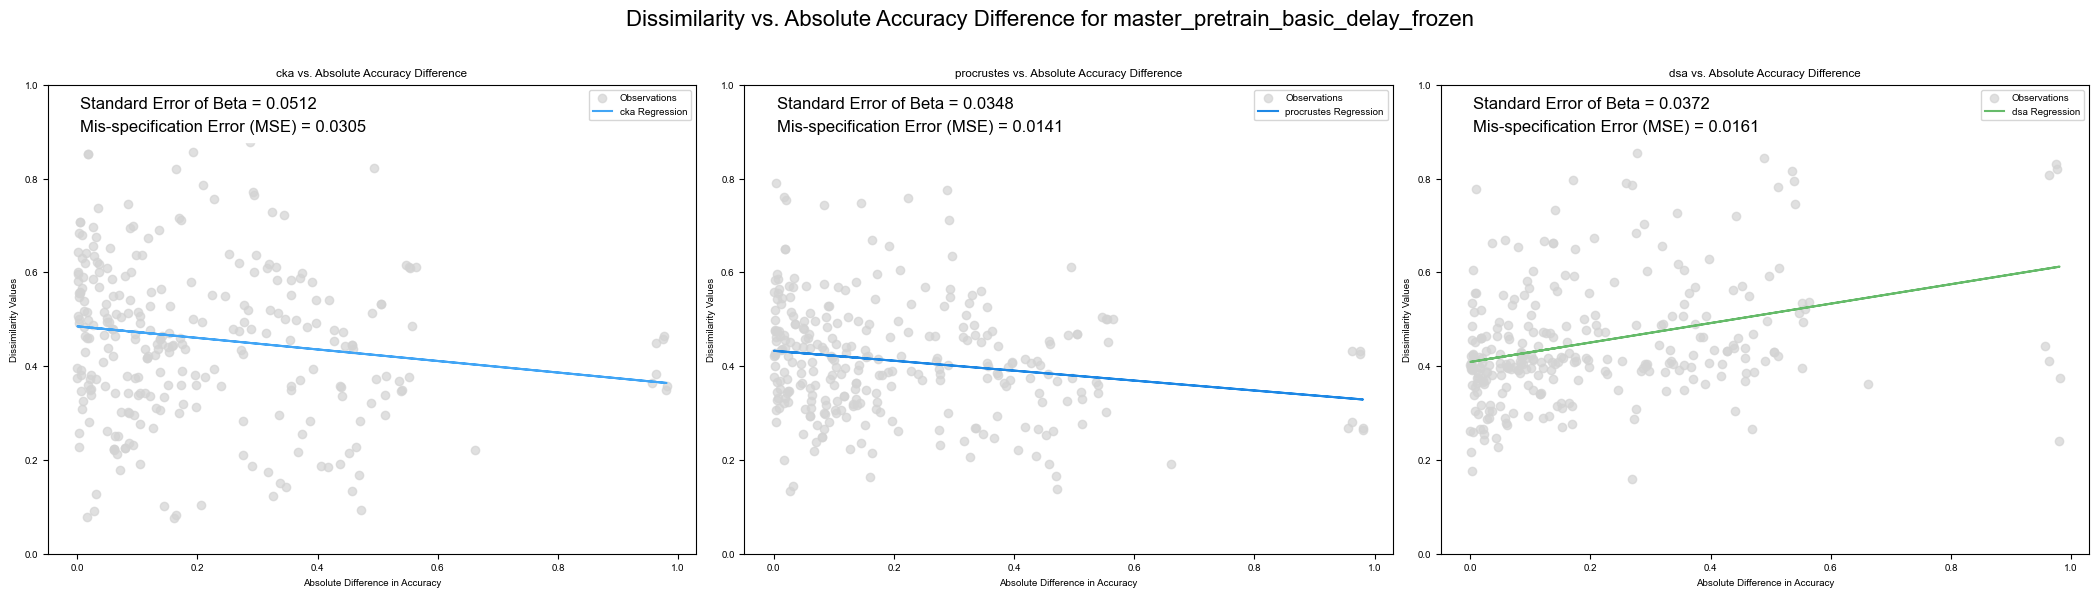

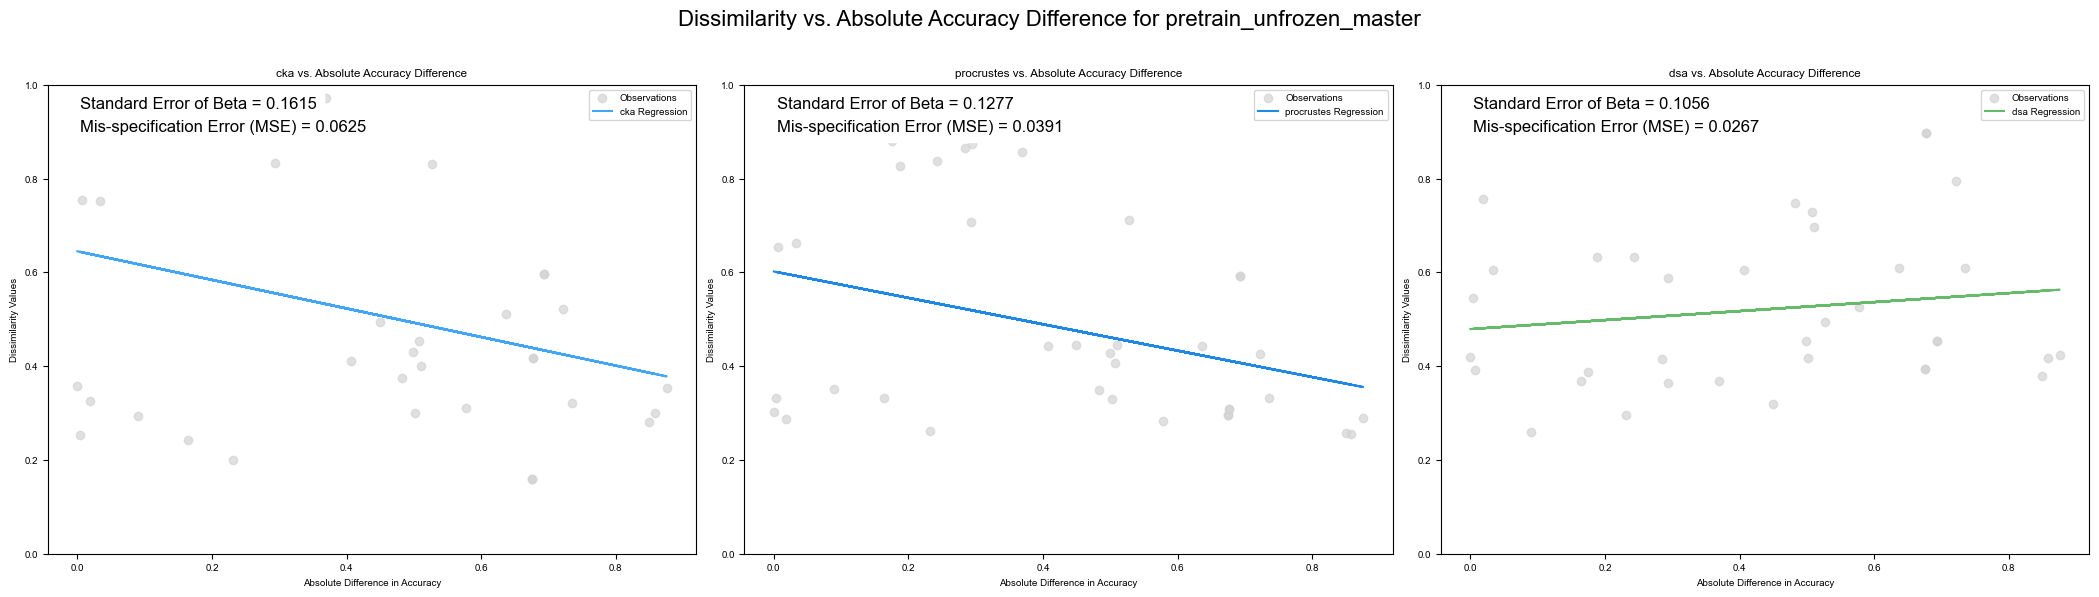

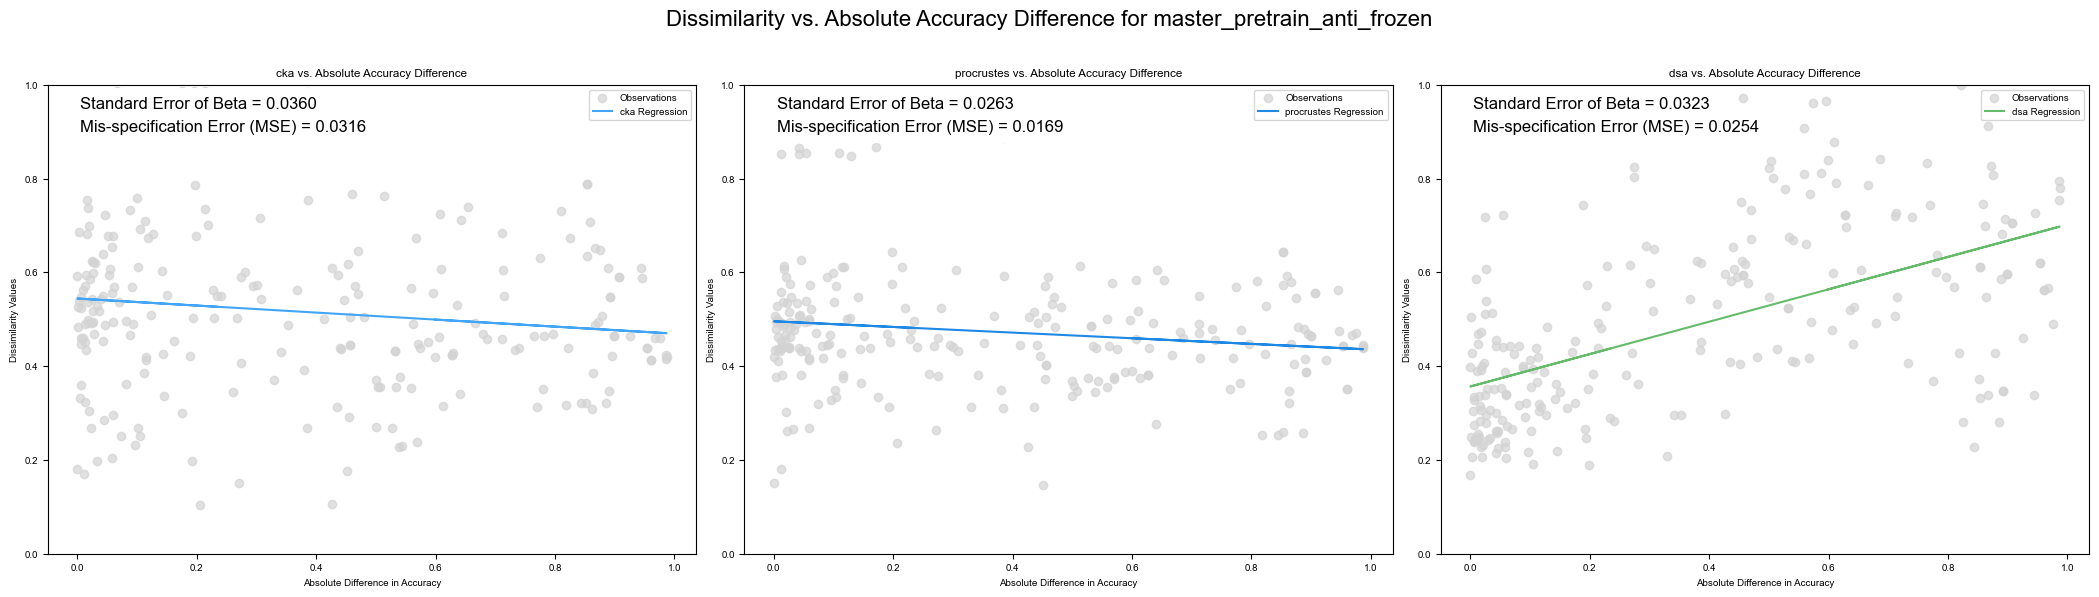

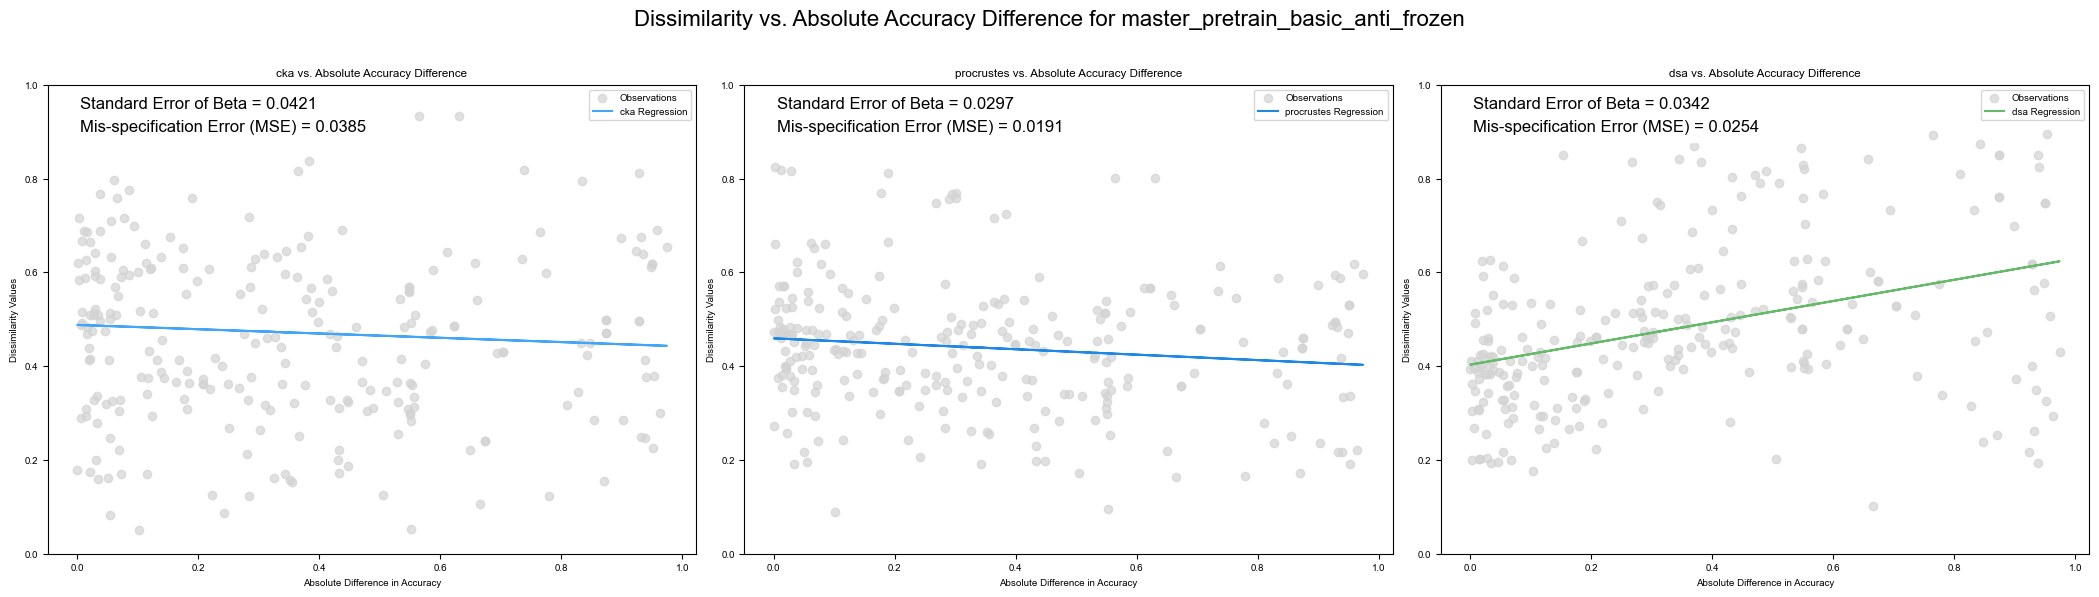

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression  # Ensure you import this

# Assuming dissimilarities_groups is defined from your previous code

# Iterate over each group in groups_training
for group_training in groups_training:
    if "master_frozen" not in group_training and "untrained" not in group_training and "master_master" not in group_training:
        dissimilarities_interpolated = dissimilarities_groups[group_training]

        # X-axis values
        x_values = [i * 20 for i in range(6)]

        # Measures for dissimilarities and accuracies
        measures_plot1 = ["cka", "procrustes", "dsa"]
        measures_plot2 = ["accuracy_1", "accuracy_2"]

        # Collect accuracy values to calculate absolute differences
        accuracy_values = {}
        for key in measures_plot2:
            dict_sampling_to_mean_and_errors = dissimilarities_interpolated[key]
            accuracy_values[key] = [
                value[2] for value in dict_sampling_to_mean_and_errors.values()
            ]
            # flatten the list
            accuracy_values[key] = [
                item for sublist in accuracy_values[key] for item in sublist
            ]

        # Calculate the absolute difference between the two accuracy measures
        abs_diff_accuracies = np.abs(
            np.array(accuracy_values["accuracy_1"])
            - np.array(accuracy_values["accuracy_2"])
        )

        # Create a figure with 3 subplots, one for each measure
        fig, axs = plt.subplots(1, 3, figsize=(21, 6))  # 1 row, 3 columns

        # Plot the dissimilarities against the absolute accuracy difference
        for idx, key in enumerate(measures_plot1):
            dict_sampling_to_mean_and_errors = dissimilarities_interpolated[key]
            dissimilarity_values = [
                value[2] for value in dict_sampling_to_mean_and_errors.values()
            ]
            # flatten the list
            dissimilarity_values = [
                item for sublist in dissimilarity_values for item in sublist
            ]

            # Ensure X and Y have the same length and remove NaNs
            X = np.array(abs_diff_accuracies)
            Y = np.array(dissimilarity_values)

            # Check for NaN values in X or Y and remove them
            valid_indices = ~np.isnan(X) & ~np.isnan(Y)
            X = X[valid_indices].reshape(-1, 1)
            Y = Y[valid_indices]

            # Plot the observations in light gray
            axs[idx].scatter(X, Y, color="lightgray", label="Observations", alpha=0.7)

            # Fit a linear regression model
            model = LinearRegression()
            model.fit(X, Y)

            # Predict y values for the regression line
            Y_pred = model.predict(X)

            # Get the slope (beta) and intercept
            beta = model.coef_[0]
            intercept = model.intercept_

            # Compute residuals and their variance
            residuals = Y - Y_pred
            residual_variance = np.var(
                residuals, ddof=2
            )  # ddof=2 because we have 2 parameters estimated (slope and intercept)

            # Compute variance of X
            X_mean = np.mean(X)
            X_variance = np.sum((X - X_mean) ** 2)

            # Standard error of the slope (beta)
            standard_error_beta = np.sqrt(residual_variance / X_variance)

            # Mis-specification error (Mean Squared Error)
            mse = np.mean(residuals**2)

            # Plot the linear regression line in the specified color
            axs[idx].plot(X, Y_pred, color=color_mapping_metrics[key], label=f"{key} Regression")

            # Annotate the plot with Standard Error of Beta and Mis-specification Error
            axs[idx].annotate(
                f"Standard Error of Beta = {standard_error_beta:.4f}",
                xy=(0.05, 0.95),
                xycoords="axes fraction",
                fontsize=12,
                bbox=dict(
                    facecolor="white", edgecolor="none", boxstyle="round,pad=0.5"
                ),
            )
            axs[idx].annotate(
                f"Mis-specification Error (MSE) = {mse:.4f}",
                xy=(0.05, 0.90),
                xycoords="axes fraction",
                fontsize=12,
                bbox=dict(
                    facecolor="white", edgecolor="none", boxstyle="round,pad=0.5"
                ),
            )

            # Set labels and title for each subplot
            axs[idx].set_xlabel("Absolute Difference in Accuracy")
            axs[idx].set_ylabel("Dissimilarity Values")
            axs[idx].set_title(f"{key} vs. Absolute Accuracy Difference")
            axs[idx].set_ylim(0, 1)
            axs[idx].legend()
            axs[idx].grid(False)

        # Set the main title for the group
        fig.suptitle(
            f"Dissimilarity vs. Absolute Accuracy Difference for {group_training}",
            fontsize=16,
        )

        # Adjust layout to avoid overlapping elements
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title

        # Display the plot
        plt.show()

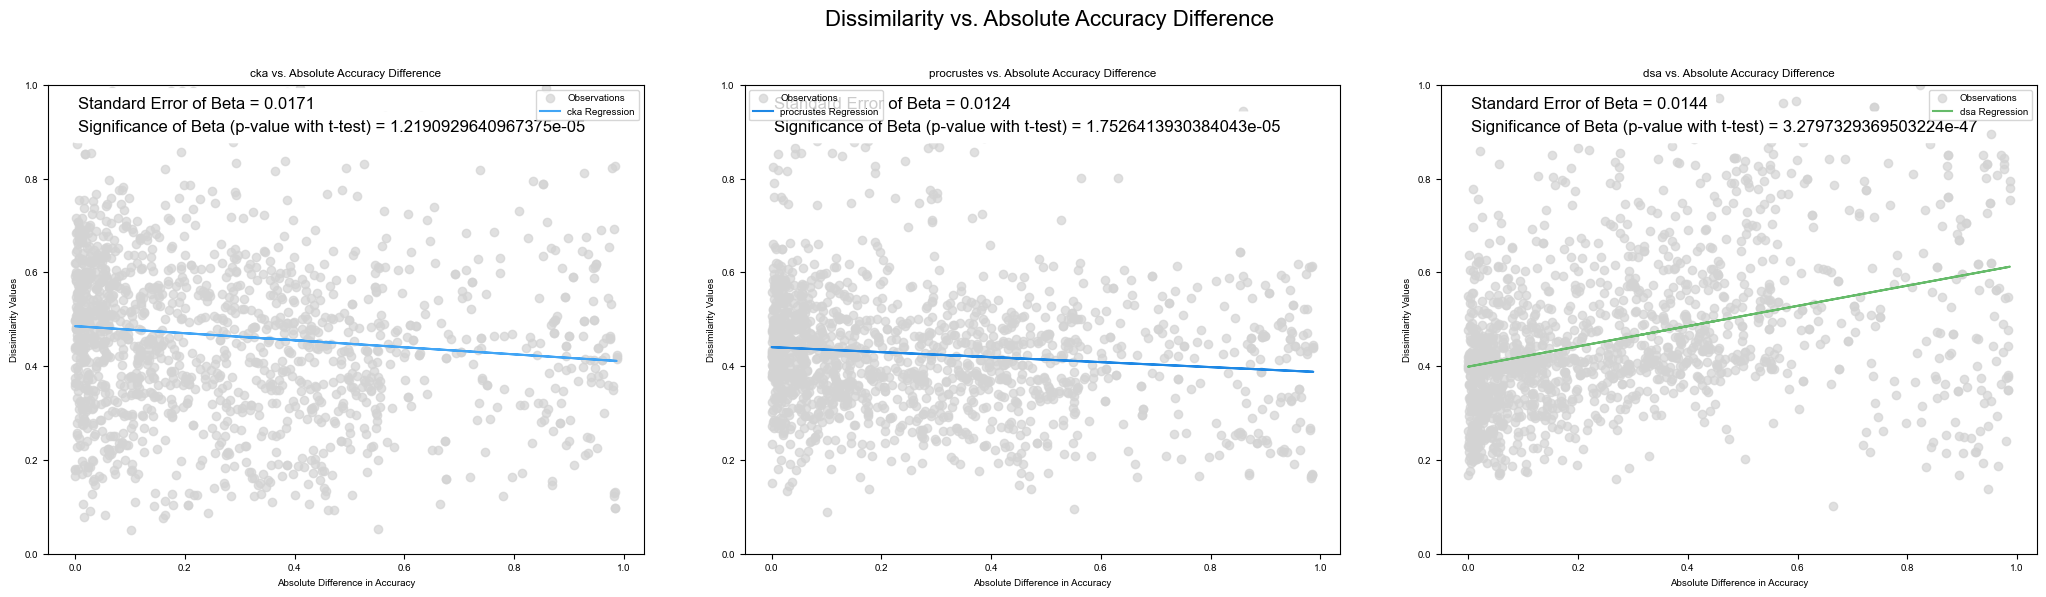

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression  # Ensure you import this

# Assuming dissimilarities_groups is defined from your previous code

# X-axis values
x_values = [i * 20 for i in range(6)]

# Measures for dissimilarities and accuracies
measures_plot1 = ["cka", "procrustes", "dsa"]
measures_plot2 = ["accuracy_1", "accuracy_2"]
# Iterate over each group in groups_training
abs_diff_accuracies_cumulated = []
dissimilarity_values_cumulated = {measure : [] for measure in measures_plot1}

for group_training in groups_training:
    if (
        "master_frozen" not in group_training
        and "untrained" not in group_training
        and "master_master" not in group_training
    ):
        dissimilarities_interpolated = dissimilarities_groups[group_training]

        # Collect accuracy values to calculate absolute differences

        for key in measures_plot2:
            dict_sampling_to_mean_and_errors = dissimilarities_interpolated[key]
            accuracy_values[key] = [
                value[2] for value in dict_sampling_to_mean_and_errors.values()
            ]
            # flatten the list
            accuracy_values[key] = [
                item for sublist in accuracy_values[key] for item in sublist
            ]

        # Calculate the absolute difference between the two accuracy measures
        abs_diff_accuracies = np.abs(
            np.array(accuracy_values["accuracy_1"])
            - np.array(accuracy_values["accuracy_2"])
        )
        abs_diff_accuracies_cumulated.extend(abs_diff_accuracies.tolist())

        # Plot the dissimilarities against the absolute accuracy difference
        for idx, key in enumerate(measures_plot1):
            dict_sampling_to_mean_and_errors = dissimilarities_interpolated[key]
            dissimilarity_values = [
                value[2] for value in dict_sampling_to_mean_and_errors.values()
            ]
            # flatten the list
            dissimilarity_values = [
                item for sublist in dissimilarity_values for item in sublist
            ]
            dissimilarity_values_cumulated[key].extend(dissimilarity_values)

# Create a figure with 3 subplots, one for each measure
fig, axs = plt.subplots(1, 3, figsize=(21, 6))  # 1 row, 3 columns

for idx, measure in enumerate(measures_plot1):
    # Ensure X and Y have the same length and remove NaNs
    X = np.array(abs_diff_accuracies_cumulated)
    Y = np.array(dissimilarity_values_cumulated[measure])

    # Check for NaN values in X or Y and remove them
    valid_indices = ~np.isnan(X) & ~np.isnan(Y)
    X = X[valid_indices].reshape(-1, 1)
    Y = Y[valid_indices]

    # Plot the observations in light gray
    axs[idx].scatter(X, Y, color="lightgray", label="Observations", alpha=0.7)

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X, Y)

    # Predict y values for the regression line
    Y_pred = model.predict(X)

    # Get the slope (beta) and intercept
    beta = model.coef_[0]
    intercept = model.intercept_

    # Compute residuals and their variance
    residuals = Y - Y_pred
    residual_variance = np.var(
        residuals, ddof=2
    )  # ddof=2 because we have 2 parameters estimated (slope and intercept)

    # Compute variance of X
    X_mean = np.mean(X)
    X_variance = np.sum((X - X_mean) ** 2)

    # Standard error of the slope (beta)
    standard_error_beta = np.sqrt(residual_variance / X_variance)

    t_statistic = beta / standard_error_beta
    df = len(X) - 2  # degrees of freedom
    p_value = 2 * stats.t.sf(np.abs(t_statistic), df)

    # Mis-specification error (Mean Squared Error)
    mse = np.mean(residuals**2)

    # Plot the linear regression line in the specified color
    axs[idx].plot(
        X, Y_pred, color=color_mapping_metrics[measure], label=f"{measure} Regression"
    )

    # Annotate the plot with Standard Error of Beta and Mis-specification Error
    axs[idx].annotate(
        f"Standard Error of Beta = {standard_error_beta:.4f}",
        xy=(0.05, 0.95),
        xycoords="axes fraction",
        fontsize=12,
        bbox=dict(
            facecolor="white", edgecolor="none", boxstyle="round,pad=0.5"
        ),
    )
    axs[idx].annotate(
        f"Mis-specification Error (MSE) = {mse:.4f}",
        xy=(0.05, 0.90),
        xycoords="axes fraction",
        fontsize=12,
        bbox=dict(
            facecolor="white", edgecolor="none", boxstyle="round,pad=0.5"
        ),
    )
    axs[idx].annotate(
        f"Significance of Beta (p-value with t-test) = {p_value}",
        xy=(0.05, 0.90),
        xycoords="axes fraction",
        fontsize=12,
        bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.5"),
    )

    # Set labels and title for each subplot
    axs[idx].set_xlabel("Absolute Difference in Accuracy")
    axs[idx].set_ylabel("Dissimilarity Values")
    axs[idx].set_title(f"{measure} vs. Absolute Accuracy Difference")
    axs[idx].set_ylim(0, 1)
    axs[idx].legend()
    axs[idx].grid(False)

# Set the main title for the group
fig.suptitle(
    f"Dissimilarity vs. Absolute Accuracy Difference",
    fontsize=16,
)

# Adjust layout to avoid overlapping elements
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title

# Display the plot
plt.show()

In [25]:
group_pairs_master = find_group_pairs_master(config, taskset)
diss_cc = get_dissimilarities_shared_task_shared_curriculum(
    group_pairs_master, dissimilarities_groups, x_values
)

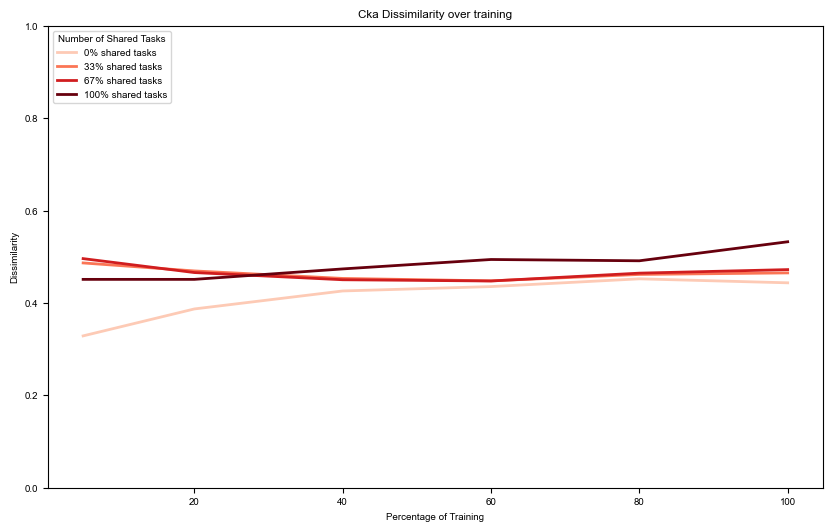

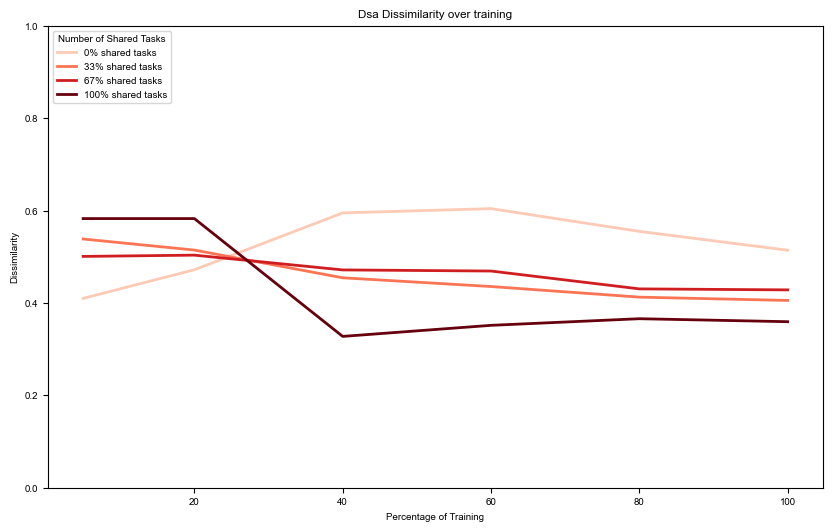

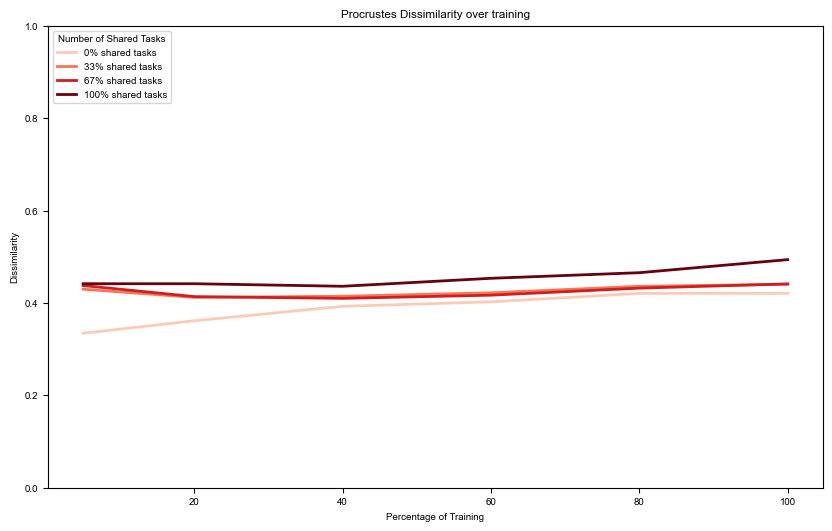

In [26]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Normalize the number of shared tasks to range between a small positive value and 1 for color mapping
all_shared_tasks = [shared for measure in diss_cc for shared in diss_cc[measure]]
min_shared = min(all_shared_tasks)
max_shared = max(all_shared_tasks)

# Set a small offset to avoid using the lightest color for 0 shared tasks
offset = 0.2  # This will push the normalization slightly to the right

# Create a colormap ranging from light to dark red
cmap = cm.Reds

# Plot each measure
for measure in diss_cc:
    plt.figure(figsize=(10, 6))  # Create a new figure for each measure
    handles = []
    labels = []

    for shared in sorted(
        diss_cc[measure].keys()
    ):  # Sort by shared tasks for plotting and legend ordering
        x_new, y_new = diss_cc[measure][shared]

        # Normalize shared task count to get a color, with the offset to avoid very light colors
        norm_shared = offset + (shared - min_shared) / (max_shared - min_shared) * (
            1 - offset
        )
        color = cmap(norm_shared)  # Get the color from the colormap

        # Plot with the determined color
        (line,) = plt.plot(
            [5]+x_new[1:], y_new, label=f"{shared} shared tasks", color=color, linewidth=2
        )
        handles.append(line)
        labels.append(f"{shared:.0f}% shared tasks")

    # Reorder the legend according to the number of shared tasks
    plt.legend(
        handles=handles, labels=labels, title="Number of Shared Tasks", loc="upper left"
    )

    plt.xlabel("Percentage of Training")
    plt.ylim(0, 1)
    plt.ylabel("Dissimilarity")
    plt.title(f"{measure.capitalize()} Dissimilarity over training")
    plt.grid(False)
    plt.show()